In [1]:
import pandas as pd
import numpy as np
import sqlite3
import joblib
import os
import json
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# --- Налаштування шляхів для збереження ---
MODELS_DIR = 'C:\\Data\\models'
LOGS_DIR = 'C:\\Data\\logs'
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

In [3]:
# --- 0. Функція для збереження Confusion Matrix ---
def save_confusion_matrix(y_true, y_pred, labels, model_name):
    """Генерує та зберігає матрицю помилок."""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {model_name} (Last Fold)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    filename = f"confusion_matrix_{model_name.replace(' ', '_').lower()}.png"
    plt.savefig(os.path.join(LOGS_DIR, filename))
    plt.close()
    print(f"  ... Матрицю помилок збережено в {os.path.join(LOGS_DIR, filename)}")
    # === ОСЬ ЗМІНА: Показ графіку ===
    plt.show()
    # ==================================
    
    plt.close() # Закриваємо фігуру, щоб уникнути накопичення
    

In [4]:
# --- 1. Зчитування даних з SQLite ---
database_file = 'C:\\Databases\\charge_database_alt.sqlite'  # <--- Ваш файл БД
TABLE_SESSIONS = 'ChargingSessions_ScaledNoAnomaly'
TABLE_USERS = 'Users_Encoded'
TABLE_VEHICLES = 'Vehicles_ScaledNoAnomaly'

try:
    conn = sqlite3.connect(database_file)
    df_sessions = pd.read_sql_query(f"SELECT * FROM {TABLE_SESSIONS}", conn)
    df_users = pd.read_sql_query(f"SELECT * FROM {TABLE_USERS}", conn)
    df_vehicles = pd.read_sql_query(f"SELECT * FROM {TABLE_VEHICLES}", conn)
    conn.close()
    print(f"Дані успішно завантажено з {database_file}")
except Exception as e:
    print(f"Помилка завантаження даних з SQLite: {e}")

Дані успішно завантажено з C:\Databases\charge_database_alt.sqlite


In [5]:
# --- 2. Об'єднання таблиць (Merging) ---
print("Об'єднання таблиць...")
df = pd.merge(df_sessions, df_users, on='user_id', how='left')
df = pd.merge(df, df_vehicles.drop(columns=['user_id'], errors='ignore'), on='vehicle_id', how='left')

Об'єднання таблиць...


In [6]:
# --- 3. Критична підготовка: Сортування за Часом ---
try:
    df['charging_start_time'] = pd.to_datetime(df['charging_start_time'])
    df = df.sort_values(by='charging_start_time').reset_index(drop=True)
    print("Дані відсортовано за 'charging_start_time'.")
except KeyError:
    print("ПОМИЛКА: Колонка 'charging_start_time' не знайдена.")
    exit()

Дані відсортовано за 'charging_start_time'.


In [7]:
# --- 4. Підготовка даних (X та Y) ---
def prepare_data(df):
    print("Підготовка фінальних X (ознак) та Y (цілі)...")
    # 4.1. Створення цільової змінної Y (Target)
    try:
        conditions = [
            df['charger_type_Level 1'] == 1,
            df['charger_type_Level 2'] == 1,
            df['charger_type_DC Fast Charger'] == 1
        ]
        choices = ['Level 1', 'Level 2', 'DC Fast Charger']
        df['Target_ChargerType'] = np.select(conditions, choices, default='Other')
        # Видаляємо 'Other', якщо вони є (наприклад, NaN)
        df = df[df['Target_ChargerType'] != 'Other']
        class_labels = sorted(df['Target_ChargerType'].unique())
        print(f"Створено цільову змінну. Класи: {class_labels}")

    except KeyError as e:
        print(f"ПОМИЛКА: Відсутня OHE колонка для створення цілі: {e}")
        exit()
    
    y_column = 'Target_ChargerType'

    # 4.2. Визначення ознак X
    columns_to_drop = [
        'session_id', 'user_id', 'vehicle_id', 'charging_station_id', 
        'charging_start_time', 'charging_end_time', 'timestamp', 
        'charging_station_location', 'time_of_day', 'day_of_week', 'vehicle_model',
        'energy_consumed_kwh', 'charging_duration_hours', 'charging_rate_kw', 
        'charging_cost_usd', 'state_of_charge_end',
        'charger_type_DC Fast Charger', 'charger_type_Level 1', 'charger_type_Level 2',
        'Target_ChargerType'
    ]
    
    existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    x_columns = df.columns.drop(existing_columns_to_drop)
    
    print(f"Цільова змінна (Y): {y_column}")
    print(f"Кількість вхідних ознак (X): {len(x_columns)}")
    
    X = df[x_columns]
    y = df[y_column]
    
    if X.isnull().sum().sum() > 0:
        print("ПОПЕРЕДЖЕННЯ: Знайдено пропуски (NaN) в X. Заповнюю нулями...")
        X = X.fillna(0)
    
    # === ЗМІНА: Повертаємо назви колонок ===
    return X, y, class_labels, list(x_columns)

# Підготовка даних
X, y, class_labels, feature_names = prepare_data(df)

Підготовка фінальних X (ознак) та Y (цілі)...
Створено цільову змінну. Класи: ['DC Fast Charger', 'Level 1', 'Level 2']
Цільова змінна (Y): Target_ChargerType
Кількість вхідних ознак (X): 8


In [8]:
# --- 5. Ініціалізація Моделей ---
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMClassifier(random_state=42, n_jobs=-1),
    "SVM": SVC(random_state=42) # Може бути дуже повільним
}

In [9]:
# --- 6. Ініціалізація TimeSeriesSplit ---
N_SPLITS = 5
tss = TimeSeriesSplit(n_splits=N_SPLITS)

In [10]:
# --- 7. Тренування та Валідація Моделей ---
all_metrics_for_db = [] # Для збереження в БД
model_testing_logs = {} # Для JSON логів

print("\n" + "="*30)
print(f"ПОЧАТОК КРОС-ВАЛІДАЦІЇ (TimeSeriesSplit, {N_SPLITS} зрізів)")
print("="*30)
for name, model in models.items():
    print(f"\nОцінка моделі: {name}")
    if name == "SVM":
        print("!!! (Це може зайняти значно більше часу) !!!")

    fold_logs_json = [] # Логи для JSON файлу цієї моделі
    
    # Списки для усереднення метрик
    metrics_train = {'acc': [], 'prec': [], 'recall': [], 'f1': []}
    metrics_val = {'acc': [], 'prec': [], 'recall': [], 'f1': []}

    for fold, (train_index, val_index) in enumerate(tss.split(X), 1):
        print(f"  Fold {fold}/{N_SPLITS}...")
        
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Тренування моделі
        model.fit(X_train, y_train)
        
        # --- Оцінка на Тренувальній вибірці (для виявлення перенавчання) ---
        y_pred_train = model.predict(X_train)
        acc_train = accuracy_score(y_train, y_pred_train)
        prec_train = precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
        rec_train = recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
        f1_train = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
        
        metrics_train['acc'].append(acc_train)
        metrics_train['prec'].append(prec_train)
        metrics_train['recall'].append(rec_train)
        metrics_train['f1'].append(f1_train)

        # --- Оцінка на Тестовій (Валідаційній) вибірці ---
        y_pred_val = model.predict(X_val)
        acc_val = accuracy_score(y_val, y_pred_val)
        prec_val = precision_score(y_val, y_pred_val, average='weighted', zero_division=0)
        rec_val = recall_score(y_val, y_pred_val, average='weighted', zero_division=0)
        f1_val = f1_score(y_val, y_pred_val, average='weighted', zero_division=0)
        
        metrics_val['acc'].append(acc_val)
        metrics_val['prec'].append(prec_val)
        metrics_val['recall'].append(rec_val)
        metrics_val['f1'].append(f1_val)

        # Додаємо детальний лог для JSON
        fold_logs_json.append({
            'fold': fold,
            'train_accuracy': acc_train, 'train_precision': prec_train, 'train_recall': rec_train, 'train_f1': f1_train,
            'val_accuracy': acc_val, 'val_precision': prec_val, 'val_recall': rec_val, 'val_f1': f1_val
        })
        
        print(f"  Fold {fold} | Train F1: {f1_train:.4f} | Val F1: {f1_val:.4f}")

        # Зберігаємо Confusion Matrix для останнього, найбільшого фолду
        if fold == N_SPLITS:
            save_confusion_matrix(y_val, y_pred_val, class_labels, name)

    # --- Усереднення метрик та збереження ---
    
    # 1. Зберігаємо детальні логи фолдів у JSON
    model_log_path = os.path.join(LOGS_DIR, f"metrics_{name.replace(' ', '_').lower()}.json")
    with open(model_log_path, 'w', encoding='utf-8') as f:
        json.dump(fold_logs_json, f, indent=4, ensure_ascii=False)
    print(f"  ... Детальні логи збережено в {model_log_path}")

    # 2. Готуємо усереднені дані для БД
    avg_metrics_db = {
        'model_name': name,
        'avg_train_accuracy': np.mean(metrics_train['acc']),
        'avg_train_precision': np.mean(metrics_train['prec']),
        'avg_train_recall': np.mean(metrics_train['recall']),
        'avg_train_f1': np.mean(metrics_train['f1']),
        'avg_val_accuracy': np.mean(metrics_val['acc']),
        'avg_val_precision': np.mean(metrics_val['prec']),
        'avg_val_recall': np.mean(metrics_val['recall']),
        'avg_val_f1': np.mean(metrics_val['f1']),
        'validation_type': 'TimeSeriesSplit',
        'n_splits': N_SPLITS
    }
    all_metrics_for_db.append(avg_metrics_db)
    
    print(f"  -> Середня F1-score (Val) для {name}: {avg_metrics_db['avg_val_f1']:.4f}")
    # --- 8. Фінальне Тренування та Збереження Моделі ---
    print(f"  ... Тренування фінальної моделі {name} на всіх даних...")
    model.fit(X, y)
    model_filename = f"{name.replace(' ', '_').lower()}.joblib"
    model_path = os.path.join(MODELS_DIR, model_filename)
    joblib.dump(model, model_path)
    print(f"  ... Модель збережено в {model_path}")


ПОЧАТОК КРОС-ВАЛІДАЦІЇ (TimeSeriesSplit, 5 зрізів)

Оцінка моделі: Logistic Regression
  Fold 1/5...
  Fold 1 | Train F1: 0.4175 | Val F1: 0.3635
  Fold 2/5...
  Fold 2 | Train F1: 0.4118 | Val F1: 0.3789
  Fold 3/5...
  Fold 3 | Train F1: 0.4129 | Val F1: 0.3016
  Fold 4/5...
  Fold 4 | Train F1: 0.3847 | Val F1: 0.3067
  Fold 5/5...
  Fold 5 | Train F1: 0.3612 | Val F1: 0.2837
  ... Матрицю помилок збережено в C:\Data\logs\confusion_matrix_logistic_regression.png
  ... Детальні логи збережено в C:\Data\logs\metrics_logistic_regression.json
  -> Середня F1-score (Val) для Logistic Regression: 0.3269
  ... Тренування фінальної моделі Logistic Regression на всіх даних...
  ... Модель збережено в C:\Data\models\logistic_regression.joblib

Оцінка моделі: Random Forest
  Fold 1/5...
  Fold 1 | Train F1: 1.0000 | Val F1: 0.3446
  Fold 2/5...
  Fold 2 | Train F1: 1.0000 | Val F1: 0.3866
  Fold 3/5...
  Fold 3 | Train F1: 1.0000 | Val F1: 0.2897
  Fold 4/5...
  Fold 4 | Train F1: 1.0000 | Va


АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК
(На основі моделей, натренованих на ВСІХ даних)

Аналіз для: Logistic Regression

Аналіз для: Random Forest

Аналіз для: LightGBM
  ... Створення графіку важливості ознак для LightGBM ...
  ... Графік важливості ознак збережено в C:\Data\logs\feature_importance_lgbm.png


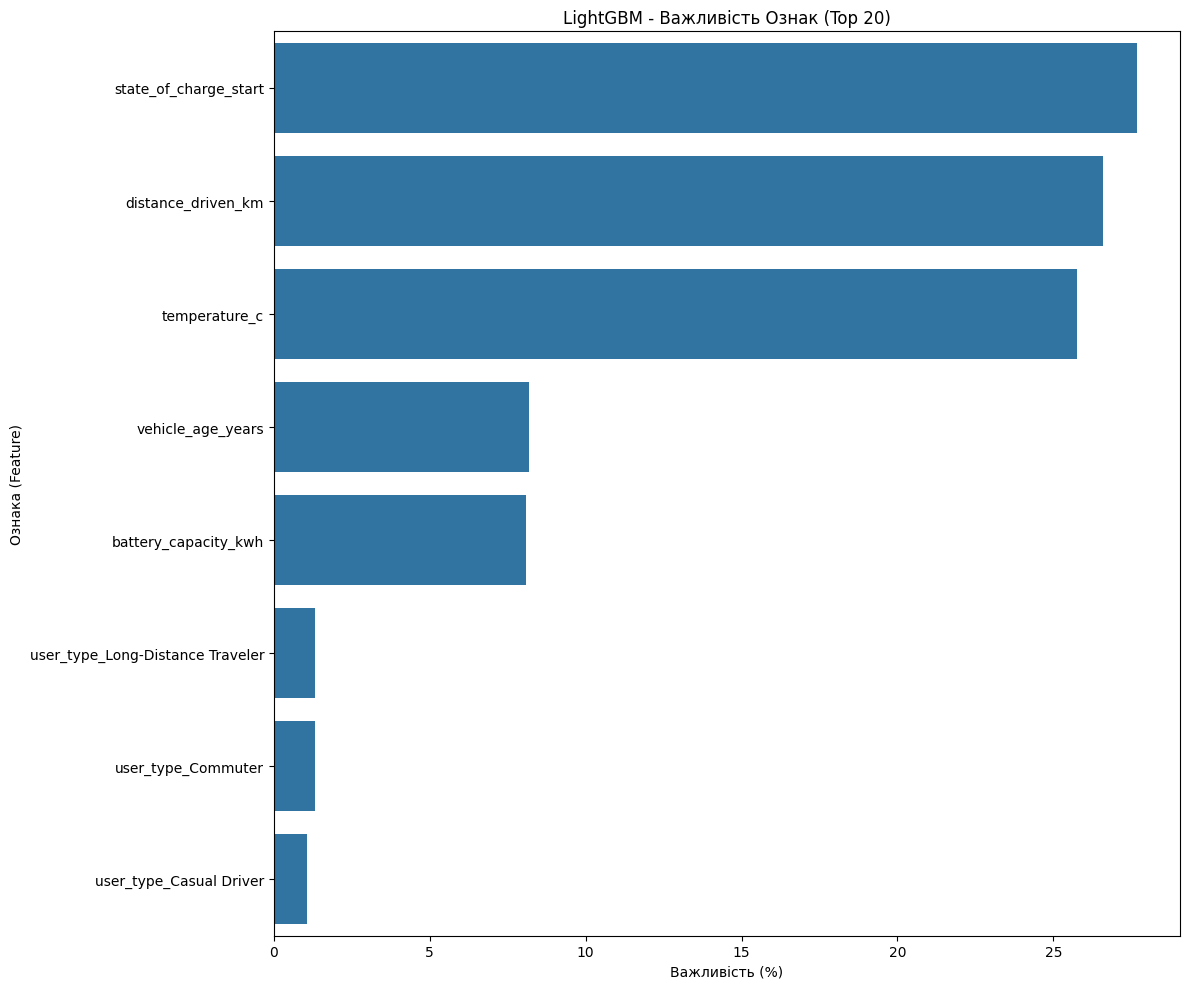


Аналіз для: SVM
  - Аналіз важливості ознак для SVM з 'rbf' ядром не підтримується.

--- Загальна Таблиця Важливості Ознак (у % вкладу для кожної моделі) ---
                                  Logistic Regression  Random Forest  LightGBM  SVM
state_of_charge_start                          10.77%         23.40%    27.68%  NaN
distance_driven_km                             16.84%         23.80%    26.58%  NaN
temperature_c                                   6.29%         23.57%    25.77%  NaN
vehicle_age_years                               3.02%         13.14%     8.19%  NaN
battery_capacity_kwh                            1.05%         11.77%     8.09%  NaN
user_type_Long-Distance Traveler               20.66%          1.51%     1.33%  NaN
user_type_Commuter                             32.26%          1.39%     1.31%  NaN
user_type_Casual Driver                         9.10%          1.42%     1.06%  NaN


In [13]:
# ==================================================================
# === 9. АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК (FEATURE IMPORTANCE) ===
# ==================================================================
print("\n" + "="*30)
print("АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК")
print("="*30)
print("(На основі моделей, натренованих на ВСІХ даних)")

feature_importance_summary = pd.DataFrame(index=feature_names)

for name, model in models.items():
    print(f"\nАналіз для: {name}")
    
    if name == "Logistic Regression":
        if hasattr(model, 'coef_'):
            importance = np.abs(model.coef_).mean(axis=0)
            importance_normalized = (importance / np.sum(importance)) * 100
            feature_importance_summary[name] = importance_normalized
        else:
            print("  - Модель не має атрибуту .coef_")

    elif name in ["Random Forest", "LightGBM"]:
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            importance_normalized = (importance / np.sum(importance)) * 100
            feature_importance_summary[name] = importance_normalized
            
            # === ГРАФІК ВАЖЛИВОСТІ ОЗНАК ДЛЯ LIGHTGBM ===
            if name == "LightGBM":
                print("  ... Створення графіку важливості ознак для LightGBM ...")
                lgbm_importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance (%)': importance_normalized
                }).sort_values(by='Importance (%)', ascending=False)
                
                # Cтворюємо графік
                plt.figure(figsize=(12, 10)) # Розмір
                sns.barplot(
                    x='Importance (%)', 
                    y='Feature', 
                    # Виводимо 20 найголовніших
                    data=lgbm_importance_df.head(20) 
                )
                plt.title('LightGBM - Важливість Ознак (Top 20)')
                plt.xlabel('Важливість (%)')
                plt.ylabel('Ознака (Feature)')
                plt.tight_layout() # Компактний лейаут
                
                # Зберігаємо графік
                plot_filename = os.path.join(LOGS_DIR, "feature_importance_lgbm.png")
                plt.savefig(plot_filename)
                print(f"  ... Графік важливості ознак збережено в {plot_filename}")
                
                # Показуємо графік
                plt.show()
            # === КІНЕЦЬ БЛОКУ ГРАФІКА ===
            
        else:
            print("  - Модель не має атрибуту .feature_importances_")
            
    elif name == "SVM":
        print("  - Аналіз важливості ознак для SVM з 'rbf' ядром не підтримується.")
        feature_importance_summary[name] = np.nan 

# Виводимо фінальну таблицю
try:
    sorted_summary = feature_importance_summary.sort_values(by="LightGBM", ascending=False)
    print("\n--- Загальна Таблиця Важливості Ознак (у % вкладу для кожної моделі) ---")
    print(sorted_summary.to_string(float_format="%.2f%%"))
except KeyError as e:
    print(f"\nНе вдалося відсортувати за LightGBM. Вивід 'як є'. Помилка: {e}")
    print(feature_importance_summary.to_string(float_format="%.2f%%"))

In [12]:
# --- 9. Збереження Усереднених Метрик в Базу Даних ---
print("\n" + "="*30)
print(f"Збереження усереднених метрик у таблицю 'model_metrics' в {database_file}...")
metrics_df = pd.DataFrame(all_metrics_for_db)

try:
    conn = sqlite3.connect(database_file)
    metrics_df.to_sql('model_metrics', conn, if_exists='replace', index=False)
    conn.commit()
    conn.close()
    print("Успіх! Метрики збережено в БД.")
except Exception as e:
    print(f"ПОМИЛКА збереження метрик в БД: {e}")

print("\n" + "="*30)
print("РОБОТУ ЗАВЕРШЕНО")
print("="*30)
print("Підсумкові усереднені метрики (Val):")
print(metrics_df[['model_name', 'avg_val_accuracy', 'avg_val_precision', 'avg_val_recall', 'avg_val_f1']].to_string(index=False))
print(f"\nНатреновані моделі збережено в директорії {MODELS_DIR}")
print(f"Матриці помилок та детальні JSON логи збережено в директорії {LOGS_DIR}")


Збереження усереднених метрик у таблицю 'model_metrics' в C:\Databases\charge_database_alt.sqlite...
Успіх! Метрики збережено в БД.

РОБОТУ ЗАВЕРШЕНО
Підсумкові усереднені метрики (Val):
         model_name  avg_val_accuracy  avg_val_precision  avg_val_recall  avg_val_f1
Logistic Regression          0.335455           0.334931        0.335455    0.326884
      Random Forest          0.337273           0.341587        0.337273    0.337313
           LightGBM          0.350909           0.352920        0.350909    0.351096
                SVM          0.328182           0.330176        0.328182    0.317851

Натреновані моделі збережено в директорії C:\Data\models
Матриці помилок та детальні JSON логи збережено в директорії C:\Data\logs
